In [2]:
import numpy as np
import pandas as pd
import math
import csv
import time
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pyarrow

import string
from langdetect import detect, detect_langs

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from collections import defaultdict
from collections import Counter

nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
ENGLISH_STOP_WORDS = set(stopwords.words("english"))

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
conf = SparkConf().setMaster("local[*]") \
    .setAll([("spark.driver.memory", "16g"),\
            ("spark.executor.memory", "8g"), \
            ("spark.driver.maxResultSize", "16g")])
sc = SparkContext.getOrCreate(conf=conf)
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

In [3]:
#spark.sparkContext.stop()

In [4]:
def getElapsedTime(startTime, endTime):
    elapsedTime = endTime - startTime
    return("Process time = %.2f seconds."%(elapsedTime))

In [5]:
def savePandasDFToParquet(csvPath, parqPath, rawSchema, printTime=False):
    startTime = time.time()
    pandasDF = pd.read_csv(csvPath, header=None)
    pandasDF.columns = rawSchema.names
    pandasDF.to_parquet(parqPath, engine="pyarrow")
    endTime = time.time()
    if printTime:
        print(getElapsedTime(startTime=startTime, endTime=endTime))
    return


In [6]:
def readSparkDFFromParquet(csvPath, parqPath, rawSchema, printTime=False):
    parquetFile = Path(parqPath)
    if (parquetFile.is_file() == False):
        print("Parquet file not found... converting %s to parquet!"%(csvPath))
        savePandasDFToParquet(csvPath=csvPath, parqPath=parqPath, rawSchema=rawSchema, printTime=printTime)
    sparkDF = spark.read.parquet(parqPath)
    return (sparkDF)


In [7]:
rawSchema = StructType([
    StructField("rating", IntegerType(), True),
    StructField("review_heading", StringType(), True),
    StructField("review_text", StringType(), True)
    ])

In [8]:
trainDF = readSparkDFFromParquet(csvPath="data/train.csv", parqPath="data/train.parquet", rawSchema=rawSchema, printTime=True)
testDF = readSparkDFFromParquet(csvPath="data/test.csv", parqPath="data/test.parquet", rawSchema=rawSchema, printTime=True)
trainDF.show(5)
print("There are %d/ %d samples in the training/ test data."%(trainDF.count(), testDF.count()))
print("Sample review text: %s"%(trainDF.take(1)[0]["review_text"]))

+------+--------------------+--------------------+
|rating|      review_heading|         review_text|
+------+--------------------+--------------------+
|     3|  more like funchuck|Gave this to my d...|
|     5|           Inspiring|I hope a lot of p...|
|     5|The best soundtra...|I'm reading a lot...|
|     4|    Chrono Cross OST|The music of Yasu...|
|     5| Too good to be true|Probably the grea...|
+------+--------------------+--------------------+
only showing top 5 rows

There are 3000000/ 650000 samples in the training/ test data.
Sample review text: Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!


In [103]:
sampleDF = trainDF.limit(10000).toPandas()
sampleDF.head()

,rating,review_heading,review_text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [104]:
sampleDF["lang"] = sampleDF.apply(lambda x: detect(x["review_text"]), axis=1)
sampleDF.drop(sampleDF[sampleDF["lang"] != "en"].index, inplace=True)
sampleDF.drop(columns="lang", inplace=True)

print("There are %d samples left after dropping non-english language reviews."%(sampleDF.shape[0]))

There are 9978 samples left after dropping non-english language reviews.


In [105]:
def plotHistograms(datasets, titles, figTitle, figSize=(18,6), numCols=1):
    fig = plt.figure(figsize=figSize)
    sns.set_theme()
    sns.set_style("white")
    
    numRows = math.ceil(len(datasets) / numCols)
    for i in range(len(datasets)):
        fig.add_subplot(numRows, numCols, i+1)
        sns.histplot(data=datasets[i])
        plt.xlabel("")
        plt.ylabel("")
        plt.title(titles[i])
    
    fig.suptitle(figTitle)
    plt.show()

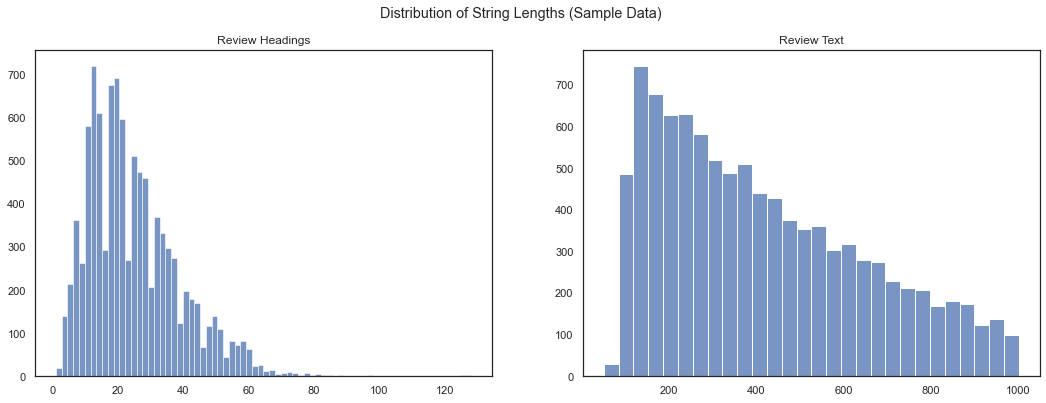

In [106]:
plotHistograms(
    datasets=[
        sampleDF['review_heading'].str.len(),
        sampleDF['review_text'].str.len()],
    titles=["Review Headings", "Review Text"],
    figTitle="Distribution of String Lengths (Sample Data)",
    figSize=(18,6), numCols=2
)

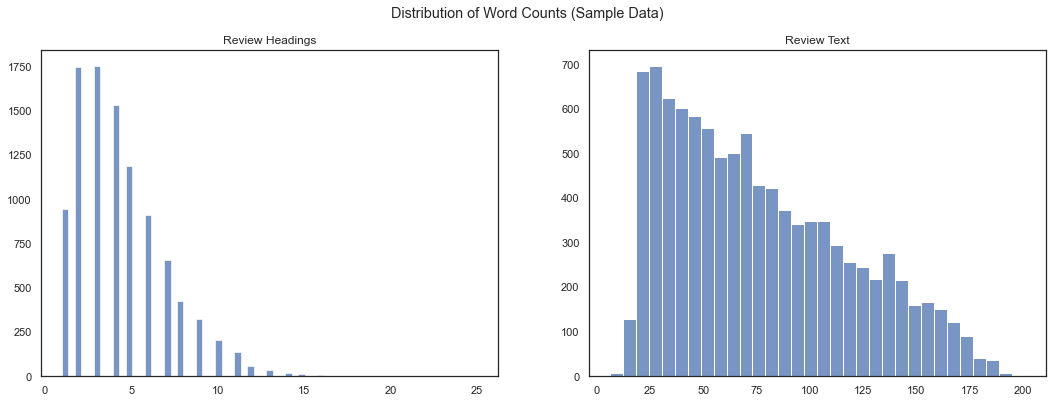

In [107]:
plotHistograms(
    datasets=[
        sampleDF['review_heading'].str.split().map(lambda x: len(x)),
        sampleDF['review_text'].str.split().map(lambda x: len(x))
        ],
    titles=["Review Headings", "Review Text"],
    figTitle="Distribution of Word Counts (Sample Data)",
    figSize=(18,6), numCols=2
)

In [14]:
def getSortedWordCounts(wordCounts, topN=0):
    sortedCounts = [[k, v] for k, v in sorted(wordCounts.items(), key=lambda item: -item[1])]
    sortedCounts = pd.DataFrame(sortedCounts, columns = ["word", "count"]) 
    if(topN > 0):
        sortedCounts = sortedCounts.head(min(topN, sortedCounts.shape[0]))
    return (sortedCounts)


In [15]:
def getWordTokensFromText(textData):
    rawTokens = word_tokenize(textData)
    cleanTokens = [w.lower().translate(str.maketrans('', '', string.punctuation)) for w in rawTokens]
    wordList = [word for word in cleanTokens if word.isalpha()]
    return (wordList)

In [16]:
def getTopWords(wordList, stopWords, topN=25):
    stopCounts = defaultdict(int)
    otherCounts = defaultdict(int)
    for word in wordList:
        if word in stopWords:
            stopCounts[word] += 1
        else:
            otherCounts[word] += 1

    topStopWords = getSortedWordCounts(stopCounts, topN)
    topOtherWords = getSortedWordCounts(otherCounts, topN)

    return ({"stopWords": topStopWords, "otherWords": topOtherWords})

In [108]:
tokenizedDF = sampleDF.copy(deep=True)
tokenizedDF["review_heading"] = [getWordTokensFromText(text) for text in tokenizedDF["review_heading"]]
tokenizedDF["review_text"] = [getWordTokensFromText(text) for text in tokenizedDF["review_text"]]

headingWords = tokenizedDF["review_heading"].apply(pd.Series).stack().reset_index(drop = True).to_list()
textWords = tokenizedDF["review_text"].apply(pd.Series).stack().reset_index(drop = True).to_list()

topHeadingWords = getTopWords(wordList=headingWords, stopWords=ENGLISH_STOP_WORDS, topN=25)
topTextWords = getTopWords(wordList=textWords, stopWords=ENGLISH_STOP_WORDS, topN=25)

print("There are %d words in the review texts of %d samples."%(len(textWords), tokenizedDF.shape[0]))


There are 765921 words in the review texts of 9978 samples.


In [37]:
def plotBars(datasets, titles, x, y, figTitle, figSize=(12,6), numCols=1):
    fig = plt.figure(figsize=figSize)
    sns.set_theme()
    sns.set_style("white")
    
    numRows = math.ceil(len(datasets) / numCols)
    for i in range(len(datasets)):
        fig.add_subplot(numRows, numCols, i+1)
        sns.barplot(data=datasets[i], x=x, y=y)
        plt.xlabel("")
        plt.ylabel("")
        plt.title(titles[i])
    fig.suptitle(figTitle)
    plt.show()

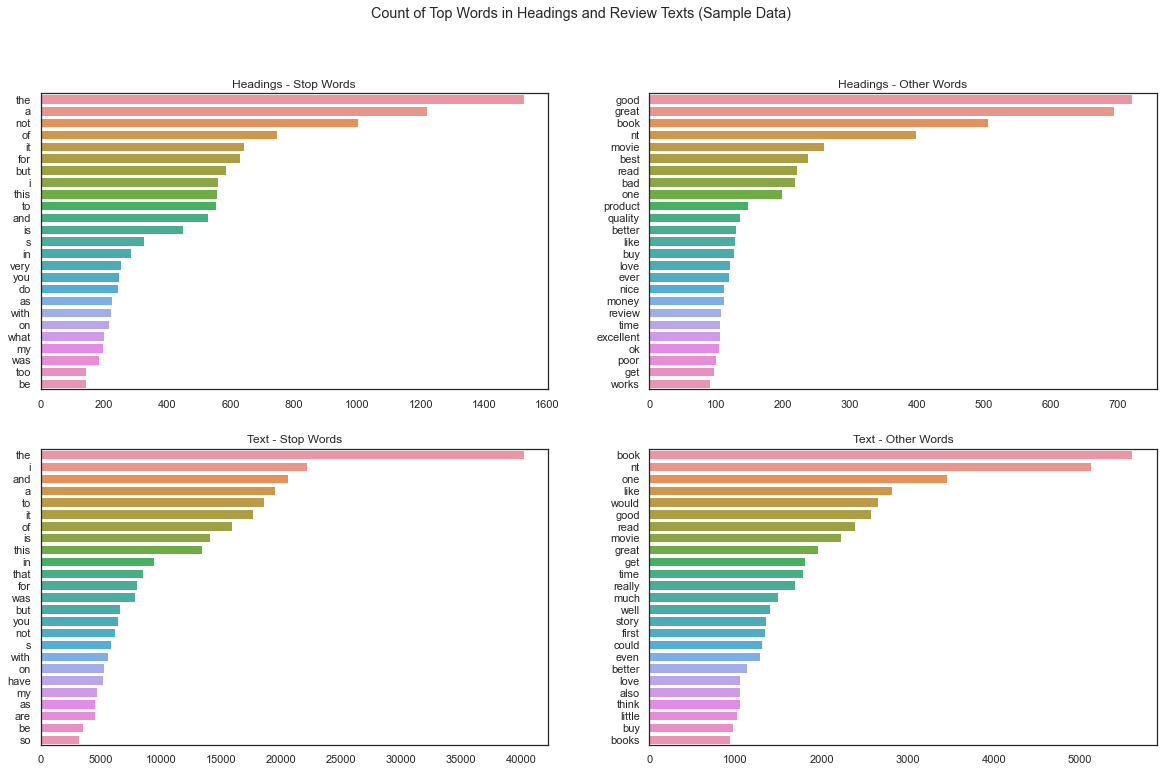

In [109]:
plotBars(
    datasets=[topHeadingWords["stopWords"], topHeadingWords["otherWords"], topTextWords["stopWords"], topTextWords["otherWords"]], 
    titles=["Headings - Stop Words", "Headings - Other Words", "Text - Stop Words", "Text - Other Words"],
    x="count", y="word", 
    figTitle="Count of Top Words in Headings and Review Texts (Sample Data)", 
    figSize=(20,12), numCols=2)

In [110]:
trainData = tokenizedDF.copy()
trainData["review_content"] = trainData["review_heading"] + trainData["review_text"]
trainData.loc[trainData["rating"] < 3, "review_sentiment"] = 0
trainData.loc[trainData["rating"] > 3, "review_sentiment"] = 1
trainData.drop(columns=["review_heading", "review_text", "rating"], inplace=True)
trainData.dropna(axis=0, inplace=True)
trainData.head()

,review_content,review_sentiment
1,"[inspiring, i, hope, a, lot, of, people, hear,...",1.0
2,"[the, best, soundtrack, ever, to, anything, i,...",1.0
3,"[chrono, cross, ost, the, music, of, yasunori,...",1.0
4,"[too, good, to, be, true, probably, the, great...",1.0
5,"[there, s, a, reason, for, the, price, there, ...",1.0


In [39]:
def removeStopWordsFromText(textData, stopWords):
    relevantText = [word for word in textData if word not in stopWords]
    return (relevantText)

In [111]:
trainData["review_content"] = [removeStopWordsFromText(text, ENGLISH_STOP_WORDS) for text in trainData["review_content"]]
trainData.head()

,review_content,review_sentiment
1,"[inspiring, hope, lot, people, hear, cd, need,...",1.0
2,"[best, soundtrack, ever, anything, reading, lo...",1.0
3,"[chrono, cross, ost, music, yasunori, misuda, ...",1.0
4,"[good, true, probably, greatest, soundtrack, h...",1.0
5,"[reason, price, reason, cd, expensive, even, v...",1.0


In [44]:
def getWordnetPos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tagDictionary = {
      "J": wordnet.ADJ,
      "N": wordnet.NOUN,
      "V": wordnet.VERB,
      "R": wordnet.ADV
      }
  return (tagDictionary.get(tag, wordnet.NOUN))

def getLemmatizedText(textData, lemmatizer):
  lemText = [lemmatizer.lemmatize(word, getWordnetPos(word)) for word in textData]
  return (lemText)

In [112]:
startTime = time.time()
lemmatizer = nltk.stem.WordNetLemmatizer()
trainData["review_content"] = [getLemmatizedText(text, lemmatizer) for text in trainData["review_content"]]
endTime = time.time()
print(getElapsedTime(startTime=startTime, endTime=endTime))
trainData.head()


Process time = 144.54 seconds.


,review_content,review_sentiment
1,"[inspire, hope, lot, people, hear, cd, need, s...",1.0
2,"[best, soundtrack, ever, anything, reading, lo...",1.0
3,"[chrono, cross, ost, music, yasunori, misuda, ...",1.0
4,"[good, true, probably, great, soundtrack, hist...",1.0
5,"[reason, price, reason, cd, expensive, even, v...",1.0


In [113]:
countVect = CountVectorizer()
reviewCounts = countVect.fit_transform(trainData["review_content"].apply(" ".join))
print("Review content is transformed into a %s with %s elements."%(type(reviewCounts), reviewCounts.shape, ))

Review content is transformed into a <class 'scipy.sparse.csr.csr_matrix'> with (7969, 25597) elements.


In [122]:
X_train, X_test, y_train, y_test =  train_test_split(reviewCounts, trainData["review_sentiment"], test_size=0.3, random_state=123)

In [123]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8126306984525303


In [97]:
tfVect = TfidfVectorizer()
reviewTF = tfVect.fit_transform(trainData["review_content"].apply(" ".join))
print("Review texts are transformed into a %s with %s elements."%(type(reviewTF), reviewTF.shape, ))

Review texts are transformed into a <class 'scipy.sparse.csr.csr_matrix'> with (770, 6109) elements.
